In [80]:

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from numpy.fft import fft, rfft
from scipy.signal import spectrogram
from matplotlib.patches import Rectangle
import warnings
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
warnings.filterwarnings("ignore")

In [10]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [ ]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

### importing

#### opto

In [ ]:
dataOp312_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-03-12\1'))

In [12]:
dataOp425_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [ ]:
dataOp621_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-21\1'))

In [ ]:
dataOp621_AL=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-21\2'))

In [ ]:
dataOp622_AL=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-22\1'))

In [ ]:
#with sine
dataOp628_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-28\3'))

In [ ]:
dataOp709_AL=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-07-09\1'))

#### stimdur

In [ ]:
dataSt521_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-05-21\1'))

In [ ]:
dataSt523_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-05-23\1'))

In [ ]:
dataSt620_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-20\3'))

In [ ]:
# with sine
dataSt625_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-25\1'))

In [ ]:
#with sine
dataSt627_AB=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-06-27\3'))

In [ ]:
dataSt624_AL=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-24\1'))

In [ ]:
#with sine
dataSt627_AL=wfOpto(Path(r'Y:\Subjects\AL_0033\2024-06-27\1'))

#### visresp

all of these - WITHOUT FLICKER!!! 

In [ ]:
#one location
dataVis809=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-09\1'))

In [ ]:
#one location
dataVis814=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-14\1'))

In [81]:
#one location
dataVis815=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-15\1'))

In [ ]:
#all 3 locations
dataVis823=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-23\3'))

In [ ]:
#3 locations
dataVis824=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-24\2'))

In [ ]:
#3 locations
dataVis825=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-25\1'))

flicker stuff starts

In [ ]:
#with flicker and then without
#:1350 and 1350:1800
dataVis830=wfOpto(Path(r'Y:\Subjects\AL_0023\2023-08-30\1'))

In [ ]:
#no flicker, idk params cause i was stupid
dataVis427_AL=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-27\1'))

In [ ]:
#with flicker
dataVis428_AL=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-28\1'))

In [ ]:
#with flicker
datavis610_AL=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-06-10\1'))

In [ ]:
#no flicker
dataVis611_AL=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-06-11\1'))

In [11]:
# process 830
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (dataVis.py, dataVis.px))
pows = np.argwhere(dataVis.laserPowers[dataVis.listExps[0]] == power).ravel()
onTimes = dataVis.laserOn[dataVis.listExps[0]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataVis.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVis.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

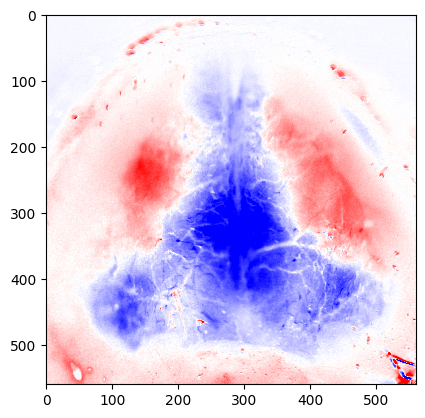

In [12]:
theseTrs = np.argwhere(dataOp.laserPowers==2).ravel()
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = dataOp.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)

avg_trial_activity = np.mean(dwf, axis=1)

spatial = dataOp.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))

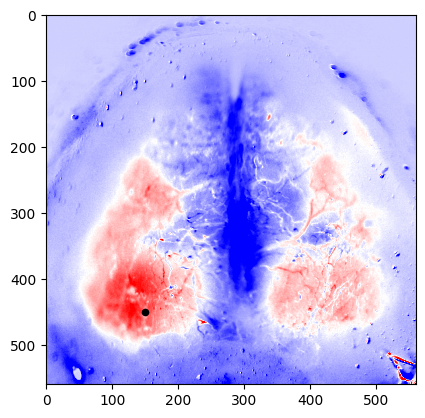

In [46]:

galvoX_val=0
galvoY_val=-0
galvoX=np.argwhere(dataOp3.galvoX==-galvoX_val).ravel()
galvoY=np.argwhere(dataOp3.galvoY==galvoY_val).ravel()

px = np.intersect1d(galvoY,galvoX)
pows = np.argwhere(dataOp3.laserPowers==2).ravel()
theseTrs=np.intersect1d(px,pows)
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = dataOp3.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)

avg_trial_activity = np.mean(dwf, axis=1)

spatial = dataOp.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
plt.scatter(x=150,y=450,s=20,color='black')

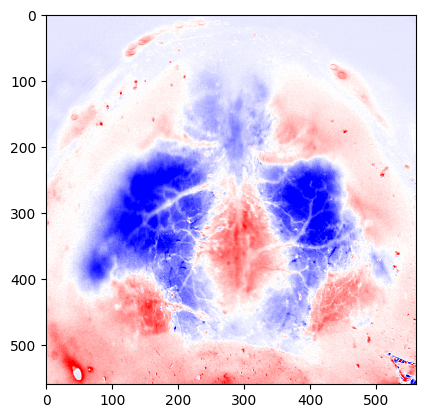

In [18]:
theseTrs = np.argwhere(dataOp4.laserPowers==2).ravel()
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = dataOp4.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)

avg_trial_activity = np.mean(dwf, axis=1)

spatial = dataOp.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))

### figure 1

- the technique works via viral injection of opsin + gcamp.
- we can track brain activity against stimulus using WF and it corresponds with ephys results. 
- we can make pretty images of the brain that correspond to the pixel values we use in analysis.

In [70]:
def brainImg(ax,data,galvoX=0,galvoY=3.3,power=2,n_samples=300):
    '''
    shows an image with specified data, X location, Y location, and laserPower
    avergaging across trials, and showing the image at the peak of activity (90th frame)
    '''
    power = np.argwhere(data.laserPowers==power).ravel() 
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel() #change for loc stim
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel() #change for loc stim

    #find trials
    px = np.intersect1d(galvoYTrs,galvoXTrs)
    theseTrs=np.intersect1d(px,power)
    allVideos=[]

    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))

    wf = np.mean(data.tToWf(trs), axis=0)

    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data.svdSpat @ dwf
    allVideos = mov.reshape(data.px, data.py, -1)
    allVideos=np.array(allVideos)

    plt.imshow(allVideos[:,:,90], cmap='bwr',clim = np.percentile(allVideos, (2, 99.9)))
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'n={len(theseTrs)}trs')
    plt.axis('off')


In [71]:
def microscope(ax):
    '''
    shows the light path, path of commands
    '''
    plt.title('microscope')
    plt.xticks([])
    plt.yticks([])
def geneExpression(ax):
    '''
    shows histology, expression of opsin + calcium
    '''
    plt.title('gene expression')
    plt.xticks([])
    plt.yticks([])


In [72]:
def wfTrace(ax,data,galvoX=0,galvoY=3.3,power=2,pixelX=200,pixelY=400,n_samples=300):
    '''
    trace of a single pixel
    purpose is to contrast with ephys data with the same pixel/location
    '''
    timestamps=np.linspace(-.3,1,n_samples)*1000

    pixel_ix=np.ravel_multi_index((pixelY,pixelX),(data.py, data.px))
    pows = np.argwhere(data.laserPowers==power).ravel()
    galvoYTrs = np.argwhere(data.galvoY==galvoY).ravel()
    galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
    locTrs=np.intersect1d(galvoXTrs,galvoYTrs)
    theseTrs=np.intersect1d(pows,locTrs)

    onTimes=data.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPower=[]
    for iT, tr in enumerate(trs):
        wf=data.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        mov=data.svdSpat[pixel_ix]@dwf
        thisPower.append(mov)
    thisPower=np.array(thisPower)

    plt.plot(timestamps,np.mean(thisPower,axis=0))
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.title(f'Pixel at {pixelX,pixelY} pow={power} n={len(theseTrs)}trs')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [78]:
def inactivation(ax,data,galvoX=0,galvoY=3.3,pixelX=200,pixelY=400,n_samples=300):
    '''
    shows inactivation over all laser powers
    '''
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((pixelY, pixelX), (data.py, data.px))
    for iP, power in enumerate(powers):
        pows = np.argwhere(data.laserPowers==power).ravel()
        galvoYTrs = np.argwhere(data.galvoY==galvoY).ravel()
        galvoXTrs=np.argwhere(data.galvoX==galvoX).ravel()
        locTrs=np.intersect1d(galvoXTrs,galvoYTrs)
        theseTrs=np.intersect1d(pows,locTrs)

        onTimes=data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for c,iP in enumerate(pxPowers):
            plt.plot(timestamps, np.mean(iP, axis=0),linewidth=1,color='k')
            plt.fill_between(timestamps, \
                    np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                    np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color='grey', label='_nolegend_',alpha=.1,linewidth=0)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')
    plt.title("Increasing Laser Powers Cause Inactivation")


In [74]:
def ephys(ax):
    '''
    trace of ephys to contrast with the single pixel activity plot
    '''
    plt.title('ephys activity')
    plt.xticks([])
    plt.yticks([])


#### panels

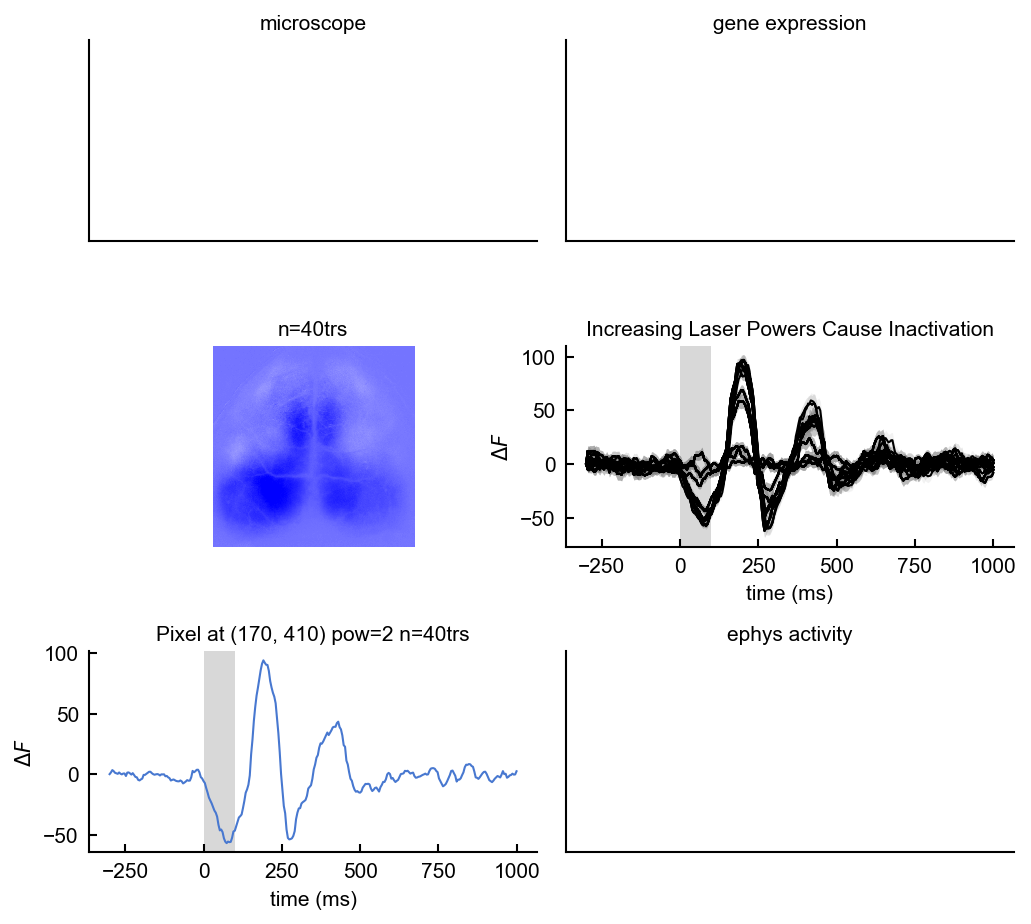

In [79]:
# figure plotting

f = plt.figure(figsize=(7,12))
gs=mpl.gridspec.GridSpec(6,2)

ax = plt.subplot(gs[0])
microscope(ax)

ax = plt.subplot(gs[1])
geneExpression(ax)

ax = plt.subplot(gs[2])
brainImg(ax,data=dataOp425_AB,galvoX=0,galvoY=3.3,power=2)

ax = plt.subplot(gs[3])
inactivation(ax,data=dataOp425_AB,galvoX=0,galvoY=3.3,pixelX=170,pixelY=410)

ax = plt.subplot(gs[4])
wfTrace(ax,data=dataOp425_AB,galvoX=0,galvoY=3.3,power=2,pixelX=170,pixelY=410)

ax = plt.subplot(gs[5])
ephys(ax)

f.tight_layout()

### figure 2

- In control mice (no opsin) red laser at certain powers and locations evokes response in visual cortex. 
- The magnitude of the visual response is reduced by adapting the retina with flicker. 
- There exists a range of laser powers that inactive neurons while not evoking a detectable visual response. 
- Light intensities used for fluorescence imaging do not drive opsin. 


In [121]:
def brainRet(ax,data,galvoX=0,galvoY=0,power=2,frame=100):
    '''
    img of the brain for fig 2.2
    an example of the VC lighting up when you stim the retina
    take one frame from avgd activity
    '''
    pows = np.argwhere(data.laserPowers==power).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY)
    galvoXTrs=np.argwhere(data.galvoX==galvoX)
    loc=np.intersect1d(galvoXTrs,galvoYTrs)
    theseTrs=np.intersect1d(loc,pows)

    trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
    trial_activity_all = data.tToWf(trial_time_all)
    trial_activity_all = np.mean(trial_activity_all, axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
    dwf = np.array(dwf)
    
    spatial = data.svdSpatFull.reshape(560*560, -1)
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1)
    
    plt.imshow(videoAvg[:,:,frame], cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

In [122]:
def traceRet(ax,data,galvoX=0,galvoY=0,power=2,pixelX=170,pixelY=400,n_samples=300):
    '''
    activity you see when stimulating the retina - trace
    '''
    power = np.squeeze(np.argwhere(data.laserPowers==power))
    galvoYTrs = np.squeeze(np.argwhere(data.galvoY==galvoY))
    galvoXTrs = np.squeeze(np.argwhere(data.galvoX==galvoX))
    locTrs=np.intersect1d(galvoXTrs,galvoYTrs)

    indexRetina = np.intersect1d(power,locTrs) #stimulation indeces - power, location top for retina
    pixel_ixRetina = np.ravel_multi_index((pixelY,pixelX),(data.py,data.px)) #what pixel to track, lower left
    onTimes = data.laserOn[indexRetina] #get all the laser ons for the indeces
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes] 
    trs = np.squeeze(np.array(trs))
    responseRet=[] 
    for iT, tr in enumerate(trs):
        wf = data.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = data.svdSpat[pixel_ixRetina] @ dwf
        responseRet.append(mov)
    responseRet = np.array(responseRet)
        
    # #stim VC
    # indexVC = np.intersect1d(power,locBot) #stimulation indeces - power, location bottom for vc
    # pixel_ixVC = np.ravel_multi_index((450,150),(dataVis.py,dataVis.px))
    # onTimes = dataVis.laserOn[indexVC]
    # trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    # trs = np.squeeze(np.array(trs))
    # responseVC=[]
    # for iT, tr in enumerate(trs):
    #     wf = dataVis.tToWFManual(tr)
    #     dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    #     dwf = np.array(dwf)
    #     mov = dataVis.svdSpat[pixel_ixVC] @ dwf
    #     responseVC.append(mov)
    # responseVC = np.array(responseVC)

    plt.plot(timestamps, np.mean(responseRet, axis=0),label='Stim Retina',color='orange')
    plt.legend(fontsize=7)
    plt.xlabel('time (ms)',fontsize=7)
    plt.ylabel('$\Delta F$',fontsize=7)
    plt.title('(Control Mouse) Visual Response',fontsize=10)

In [123]:
def visrespQuant(ax,data,galvoX=0,galvoY=0,n_samples=300,pixelY=400,pixelX=120):
    '''
    quantifying how much response there is for how much power (JUST on retina)
    '''
    powers = np.unique(data.laserPowers)
    pxPowersRetina=[]
    # pxPowersVC=[]

    pixel_ix= np.ravel_multi_index((pixelY,pixelX),(data.py,data.px))

    galvoXTrs = np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY).ravel()
    trsRetina=np.intersect1d(galvoXTrs,galvoYTrs)
    # trsVC = np.argwhere(data.galvoY==2.5).ravel()

    for iP, power in enumerate(powers):
        if power >= 0:
            trsPower = np.argwhere(data.laserPowers==power).ravel()
            
            #retina
            onTimesRetina = np.intersect1d(trsRetina,trsPower)
            theseTrsRet = [np.linspace(on+-.3,on+1,n_samples) for on in onTimesRetina]
            theseTrsRet = np.squeeze(np.array(theseTrsRet))
            thisPowerRetina=[]
            for iT, tr in enumerate(theseTrsRet):
                wf=data.tToWFManual(tr)
                dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data.svdSpat[pixel_ix] @ dwf
                thisPowerRetina.append(mov)
            thisPowerRetina = np.array(thisPowerRetina)
            pxPowersRetina.append(thisPowerRetina)

            # #VC
            # onTimesVC = np.intersect1d(trsVC, trsPower)
            # theseTrsVC = [np.linspace(on+-.3,on+1,n_samples) for on in onTimesVC]
            # theseTrsVC = np.squeeze(np.array(theseTrsVC))
            # thisPowerVC=[]
            # for iT, tr in enumerate(theseTrsVC):
            #     wf=dataVis.tToWFManual(tr)
            #     dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
            #     dwf = np.array(dwf)
            #     mov = dataVis.svdSpat[pixel_ix] @ dwf
            #     thisPowerVC.append(mov)
            # thisPowerVC = np.array(thisPowerVC)
            # pxPowersVC.append(thisPowerVC)
    retinaInt=[]
    time=np.linspace(-.3,1,650)
    for count,pxPowers in enumerate(pxPowersRetina):
        pxPowers = np.mean(pxPowers,axis=0)
        min=np.min(pxPowers)
        pxPowers=pxPowers+(min*-1)
        int=np.trapz(y=pxPowers)
        retinaInt.append(int)
    retinaInt = np.array(retinaInt)

    # vcInt=[]
    # for count,pxPowers in enumerate(pxPowersVC):
    #     pxPowers = np.mean(pxPowers,axis=0)
    #     min=np.min(pxPowers)
    #     pxPowers=pxPowers+(min*-1)
    #     int=np.trapz(y=pxPowers)
    #     vcInt.append(int)
    # vcInt = np.array(vcInt)

    dotkwargs={'marker':'.', 'yerr':0}
    constant=100

    plt.errorbar(np.unique(data.laserPowers),retinaInt/constant,c='green',label='stim retina',**dotkwargs)
    # plt.errorbar(np.unique(dataVis.laserPowers),vcInt/constant,c='orange',label='stim VC',**dotkwargs)
    plt.legend(fontsize=7)
    plt.xlabel('Optogenetic Laser Power mW',fontsize=7)
    plt.ylabel('Visual Response',fontsize=7)     
    plt.title('Magnitude of Visual Response',fontsize=10)            
    

In [82]:
def brainMid(ax):
    '''
    shows the brian and thus visresp when you stimulate in the middle
    '''
    pass

In [83]:
def traceMid(ax):
    '''
    shows the trace of activity when you stimulate in the middle
    '''
    pass

In [84]:
def brainVC(ax):
    '''
    shows the brain and thus visresp when you stimulate vc
    '''
    pass

In [85]:
def traceVC(ax):
    '''
    shows the trace of activity when you stimualte VC
    '''

In [28]:
def adaptTrace(ax):
    '''
    shows the trace when adapting the response, and when not adapting the response
    shoudl be stimulating retina
    '''
    pixel = (410, 428)
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    power=3
    pixel_ix = np.ravel_multi_index((428, 410), (dataVis2.py, dataVis2.px))
    pows = np.argwhere(dataVis2.laserPowers[dataVis2.listExps[1]] == power).ravel()
    onTimes = dataVis2.laserOn[dataVis2.listExps[1]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    noFlicker = []
    for iT, tr in enumerate(trs):
        wf = dataVis2.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataVis2.svdSpat[pixel_ix] @ dwf
        noFlicker.append(mov)
    noFlicker = np.array(noFlicker)
    # plt.plot(timestamps, np.mean(noFlicker, axis=0))
    # plt.title(f'power {power}')
    # plt.xlabel('time (ms)')
    # plt.ylabel('$\Delta F$')
    colors = ['forestgreen', 'darkorange']
    plt.plot(timestamps, np.mean(noFlicker, axis=0), color=colors[0], label='without flicker')
    plt.fill_between(timestamps, \
                     np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                     np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color=colors[0], alpha=0.3, lw=0, label='_nolegend_')
    
    plt.plot(timestamps, np.mean(flicker,axis=0),color=colors[1], label='with flicker')
    plt.fill_between(timestamps, \
                     np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                     np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color=colors[1], lw=0, label='_nolegend_', alpha=0.3)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.legend(fontsize=7)
    plt.ylim(None, 30)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset(s)',fontsize=7)
    plt.ylabel('Visual response',fontsize=7)
    plt.title(f'{power} mW opto stim',fontsize=10)

In [29]:
def adaptQuant(ax):
    '''
    quantifying how much visual response there is for which power
    '''
    powers = np.unique(dataVis2.laserPowers)
    pixel = (410, 428)
    pxPowersFlicker = [] 
    pxPowersNoFlicker = []
    n_samples = 650
    
    pixel_ix = np.ravel_multi_index((428, 410), (dataVis2.py, dataVis2.px))
    for iP, power in enumerate(powers):
        if power >= 0:
            theseTrsFlicker = np.argwhere(dataVis2.laserPowers[dataVis2.listExps[0]]== power).ravel()
            # theseTrsFlicker=theseTrsFlicker[::3]
            onTimesFlicker = dataVis2.laserOn[dataVis2.listExps[0]][theseTrsFlicker]
            trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
            trsFlicker = np.squeeze(np.array(trsFlicker))
            
            theseTrsNFlicker = np.argwhere(dataVis2.laserPowers[dataVis2.listExps[1]]== power).ravel()
            onTimesNFlicker = dataVis2.laserOn[dataVis2.listExps[1]][theseTrsNFlicker]
            trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
            trsNFlicker = np.squeeze(np.array(trsNFlicker))
            
            thisPowerNFlicker = []
            thisPowerFlicker = []
            for iT, tr in enumerate(trsFlicker):
                wf = dataVis2.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = dataVis2.svdSpat[pixel_ix] @ dwf
                thisPowerFlicker.append(mov)
            thisPowerFlicker = np.array(thisPowerFlicker)
            pxPowersFlicker.append(thisPowerFlicker)
    
            for iT, tr in enumerate(trsNFlicker):
                wf = dataVis2.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = dataVis2.svdSpat[pixel_ix] @ dwf
                thisPowerNFlicker.append(mov)
            thisPowerNFlicker = np.array(thisPowerNFlicker)
            pxPowersNoFlicker.append(thisPowerNFlicker)   
    
    flickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        flickInt.append(int)
    flickInt = np.array(flickInt)
    
    noflickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersNoFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        noflickInt.append(int)
    noflickInt = np.array(noflickInt)
    # plt.plot(np.unique(dataVis2.laserPowers),noflickInt,c='red')

    dotkwargs = {'marker': '.', 'yerr': 0}
    constant = 100
    plt.errorbar(np.unique(dataVis2.laserPowers), noflickInt/constant, c='forestgreen', label='without flicker', **dotkwargs)
    
    # plt.plot(np.unique(dataVis2.laserPowers),flickInt,c='blue')
    plt.errorbar(np.unique(dataVis2.laserPowers), flickInt/constant, c='darkorange', label='with flicker', **dotkwargs)
    
    plt.legend(fontsize=7)
    plt.xlabel('Optogenetic laser power (mW)',fontsize=7)
    plt.ylabel('Visual response',fontsize=7)
    plt.title('Magnitude of Visual Response',fontsize=10)

In [30]:
def opsinLight(ax):
    plt.title('Opsin light doesnt drive gcamp')

#### panels fig 2.2

IndexError: index 100 is out of bounds for axis 2 with size 100

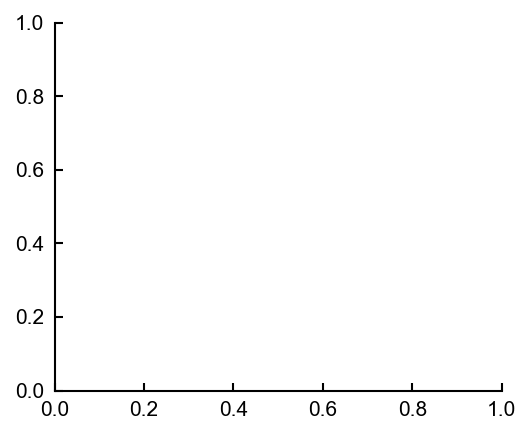

In [124]:
# figure plotting

f = plt.figure(figsize=(10,3))
gs=mpl.gridspec.GridSpec(1,3)

ax = plt.subplot(gs[0])
brainRet(ax,data=dataVis815,galvoX=1,frame=100)

ax = plt.subplot(gs[1])
traceRet(ax,data=dataVis815,galvoX=1,pixelX=150,pixelY=400)

ax = plt.subplot(gs[2])
visrespQuant(ax,data=dataVis815,galvoX=1,pixelX=150,pixelY=400)

##### gif time

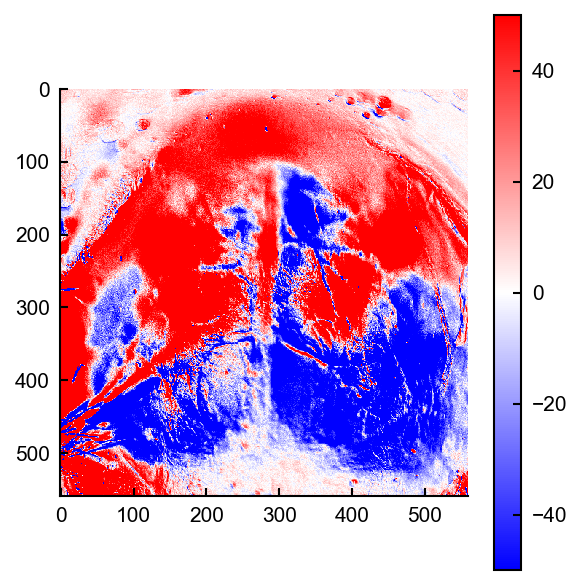

In [117]:
data=dataVis815;galvoX=1;galvoY=-0;power=2;n_samples=300

pows = np.argwhere(data.laserPowers==power).ravel()
galvoYTrs=np.argwhere(data.galvoY==galvoY)
galvoXTrs=np.argwhere(data.galvoX==galvoX)
loc=np.intersect1d(galvoXTrs,galvoYTrs)
theseTrs=np.intersect1d(loc,pows)

trial_time_all = [np.linspace(i+-.3, i+1, n_samples) for i in theseTrs]
trial_activity_all = data.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)


spatial = data.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)

#find when the stim is on
f=plt.figure(figsize=(4, 4))

#make sure n_samples and timestamps are consistent between this code and the img making code - especially when youre making the trials for the images
timestamps=np.linspace(-.1,1,n_samples)*1000
stimOn = np.intersect1d(np.argwhere(timestamps > 0).ravel(), np.argwhere(timestamps < 100).ravel())
ax=plt.subplot()
clim=np.percentile(videoAvg,(2,99.9)) 
img = plt.imshow(videoAvg[:,:,0],cmap='bwr',clim=np.r_[-1, 1]*50)
plt.colorbar()
stext = plt.text(0.1, 0.999, '', fontsize='large', transform=ax.transAxes, zorder=20)

#set up the frames to loop through for the animation
def animate(i):
    img.set_array(videoAvg[:,:,i])
    f.suptitle(f't = {timestamps[i]:.0f} ms',size=15)
    if np.isin(i, stimOn):
        stext.set_text('STIM ON')
        stext.set_color('red')
    else:
        stext.set_text('STIM OFF')
        stext.set_color('k')


In [118]:
anim = mpl.animation.FuncAnimation(f, animate, frames=n_samples-1, cache_frame_data=False, interval=1)

AttributeError: module 'matplotlib' has no attribute 'animation'

In [119]:
savepath = 'C:/Users/nadia/Downloads/gif/visresp.gif'

writergif=mpl.animation.PillowWriter(fps=60)
anim.save(savepath,writer=writergif)

AttributeError: module 'matplotlib' has no attribute 'animation'

#### panels fig 2.4

In [ ]:
f=plt.figure(figsize=(6,15))
gs=mpl.gridspec.GridSpec(1,6)

ax=plt.subplot(gs[0])
brainRet(ax)

ax=plt.subplot(gs[1])
traceRet(ax)

ax=plt.subplot(gs[2])
brainMid(ax)

ax=plt.subplot(gs[3])
traceMid(ax)

ax=plt.subplot(gs[4])
brainVC(ax)

ax=plt.subplot(gs[3])
traceVC(ax)

#### panels fig 2.6

In [ ]:
f=plt.figure(figsize=(6,15))
gs=mpl.gridspec.GridSpec(1,1)

ax=plt.subplot(gs[0])
adaptTrace(ax)

ax=plt.subplot(gs[1])
adaptQuant(ax)

### figure 3

- there is temporal spread
- there is spatial spread
- spread and activation depends on power 
- it is consistent over months 

tbd:
- with flicker
- day-to-day

In [265]:
def temporalRes(ax):
    '''
    temportal resolution across powers
    '''
    powers = np.unique(dataOp.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp.py, dataOp.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp.laserPowers == power).ravel()
        onTimes = dataOp.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for iP in pxPowers:
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),color='k')
        # plt.legend(['.1', '.2', '.5', '.7', '1.0', '1.2', '1.5', '1.7', '2.0'], loc='right')
        plt.axvline(x=90)
        plt.xlabel('time (ms)')
        plt.ylabel('$\Delta F$')
        plt.title('temporal resolution')


In [266]:
def temportalQuant(ax):
    '''
    quantification of temporal spread. half width
    '''
    powers = np.unique(dataOp.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp.py, dataOp.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp.laserPowers == power).ravel()
        onTimes = dataOp.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        half_widths=[]
    for iP in pxPowers:
        iP = np.mean(iP,axis=0)
        iP = iP*-1
        peaks,properties=scipy.signal.find_peaks(iP,height=[None,None],width=[None,None],distance=250)
        widths = scipy.signal.peak_widths(iP,peaks)
        half_widths.append(widths[0][0])
    plt.plot(powers,half_widths,color='k',linewidth=1.5)
    plt.title('Half Widths - Time',fontsize=10)
    plt.xlabel('Powers',fontsize=7)
    plt.ylabel('Peak Width',fontsize=7)
            


In [267]:
def spatialResX(ax):
    '''
    spatial resolution
    how to do this? along lines or do an ROI?
    '''
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power)) # find trials
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

        activity = dataOp.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
        
        activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
        dwf = np.array(dwf)
        avg = np.mean(dwf, axis=1)
        
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
        # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
        videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
        videoROI = videoAvg[250, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)

    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        data = spreadByPower[count]
        data = gaussian_filter1d(data, sigma=2)
        plt.plot(data,c='k') 
    # plt.title("Spatial spread over horizontal line")
    plt.xlabel("location 560:560")
    plt.ylabel("activity")

    plt.title('spatial resolution')


Text(0.5, 1.0, 'spatial resolution stim (0, 0)')

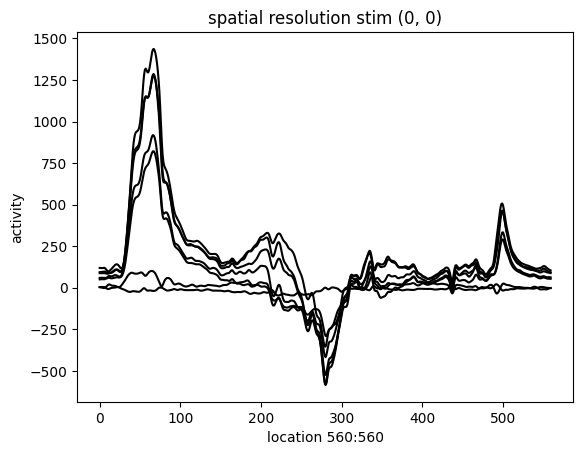

In [57]:
#spread op3
spreadByPower = []
spatial = dataOp.svdSpatFull.reshape(560*560, -1)

galvoX_val=0
galvoY_val=0
galvoX=np.argwhere(dataOp3.galvoX==-galvoX_val).ravel()
galvoY=np.argwhere(dataOp3.galvoY==galvoY_val).ravel()

px = np.intersect1d(galvoY,galvoX)
for count,power in enumerate(np.unique(dataOp3.laserPowers)):
    pows = np.squeeze(np.argwhere(dataOp3.laserPowers==power)) # find trials
    trials = np.intersect1d(pows,px)
    time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp3.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

    activity = dataOp3.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
    
    activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
    
    dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
    dwf = np.array(dwf)
    avg = np.mean(dwf, axis=1)
    
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
    # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
    videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
    videoROI = videoAvg[150, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
    
    spreadByPower.append(videoROI)
spreadByPower = np.array(spreadByPower)

for count,power in enumerate(np.unique(dataOp3.laserPowers)):
    data = spreadByPower[count]
    data = gaussian_filter1d(data, sigma=2)
    plt.plot(data,c='k') 
# plt.title("Spatial spread over horizontal line")
plt.xlabel("location 560:560")
plt.ylabel("activity")

plt.title(f'spatial resolution stim {galvoX_val,galvoY_val}')

Text(0.5, 1.0, 'spatial resolution stim (3.3, 3.3)')

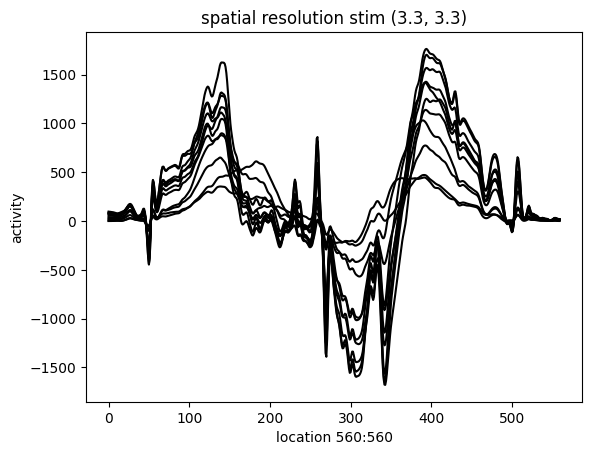

In [61]:
#spread op4
spreadByPower = []
spatial = dataOp4.svdSpatFull.reshape(560*560, -1)

galvoX_val=3.3
galvoY_val=3.3
galvoX=np.argwhere(dataOp4.galvoX==galvoX_val).ravel()
galvoY=np.argwhere(dataOp4.galvoY==galvoY_val).ravel()

px = np.intersect1d(galvoY,galvoX)

for count,power in enumerate(np.unique(dataOp4.laserPowers)):
    pows = np.squeeze(np.argwhere(dataOp4.laserPowers==power)) # find trials
    trials=np.intersect1d(px,pows)
    time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp4.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

    activity = dataOp4.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
    
    activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
    
    dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
    dwf = np.array(dwf)
    avg = np.mean(dwf, axis=1)
    
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
    # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
    videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
    videoROI = videoAvg[130, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
    
    spreadByPower.append(videoROI)
spreadByPower = np.array(spreadByPower)

for count,power in enumerate(np.unique(dataOp4.laserPowers)):
    data = spreadByPower[count]
    data = gaussian_filter1d(data, sigma=2)
    plt.plot(data,c='k') 
# plt.title("Spatial spread over horizontal line")
plt.xlabel("location 560:560")
plt.ylabel("activity")

plt.title(f'spatial resolution stim {galvoX_val,galvoY_val}')

In [286]:
def xQuant(ax):
    '''
    quantifying spatial resolution. also half-width?
    '''
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power)) # find trials
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]] # find times for trials. length 50 bc 50 trials --> each have 100 times 

        activity = dataOp.tToWFManual(time) # 50x100x500. 50 trials, 100 times each, 500 components
        
        activity = np.mean(activity, axis=0) # 100x500. activity averaged across trials. 100 times, 500 compoennets, all an average of all trials
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity] #100x500, just a correction
        dwf = np.array(dwf)
        avg = np.mean(dwf, axis=1)
        
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1) #560x560x100 pixelsxtime
        # videoAvg = np.mean(videoAvg, axis=2) # deleted bc averaging over time causes issues, since stim is on/off
        videoAvg = videoAvg[:,:,0] # 560x560. picking one time point. 
        videoROI = videoAvg[230:270, :] # 560 horizontal pixels. taken from avg activity, the average activity for all trials and all times accross one line 
        videoROI = np.mean(videoAvg,axis=(0))
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)

    half_widths=[]
    for power in spreadByPower:
        peaks,properties=scipy.signal.find_peaks(power,height=[None,None],width=[None,None],distance=100)
        widths = scipy.signal.peak_widths(power,peaks)
        half_widths.append(widths[0][0])
    plt.plot(half_widths,color='k',linewidth=1.5)
    plt.title('Half Widths - Space',fontsize=10)
    plt.xlabel('Powers',fontsize=7)
    plt.ylabel('Peak Width',fontsize=7)


In [269]:
def powerDep(ax):
    '''
    how power impacts inactivation
    '''
    powers = np.unique(dataOp.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp.py, dataOp.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp.laserPowers == power).ravel()
        onTimes = dataOp.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k')
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.xlabel("powers")
    plt.ylabel("inhibition")
    plt.title("effect at peak (90 ms)")



In [270]:
def activityPast(ax):
    '''
    how activity was looking 6mo ago
    simple trace
    '''
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    galvoLoc=0

    pixel_ix=np.ravel_multi_index((428,410),(dataOp.py, dataOp.px))
    pows = np.argwhere(dataOp.laserPowers==power).ravel()
    galvoY = np.argwhere(dataOp.galvoY==galvoLoc).ravel()
    theseTrs=np.intersect1d(pows,galvoY)
    onTimes=dataOp.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPower=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        mov=dataOp.svdSpat[pixel_ix]@dwf
        thisPower.append(mov)
    thisPower=np.array(thisPower)
    plt.plot(timestamps,np.mean(thisPower,axis=0))
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.title(f'Activity on 8/16')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')


In [271]:
def activityPresent(ax):
    '''
    how it is looking 6mo after
    simple trace
    '''
    plt.title('Activity (2024)')


#### panels

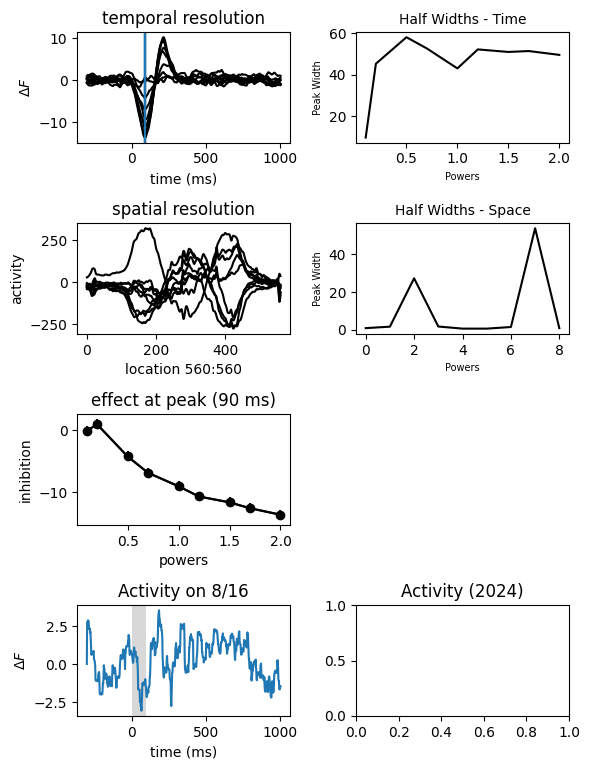

In [287]:
# figure plotting

f = plt.figure(figsize=(6,15))
gs=mpl.gridspec.GridSpec(8,2)

ax = plt.subplot(gs[0])
temporalRes(ax)

ax = plt.subplot(gs[1])
temportalQuant(ax)

ax = plt.subplot(gs[2])
spatialResX(ax)

ax = plt.subplot(gs[3])
xQuant(ax)

ax = plt.subplot(gs[4])
powerDep(ax)

ax = plt.subplot(gs[6])
activityPast(ax)

ax = plt.subplot(gs[7])
activityPresent(ax)

f.tight_layout()

#### Spatial Options

In [49]:
def spatialResY(ax):
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)
            
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        # videoAvg = np.mean(videoAvg, axis=2)
        videoAvg = videoAvg[:,:,0]
        videoROI = videoAvg[:, 200] # activity across one line
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        data = spreadByPower[count]
        data = gaussian_filter1d(data, sigma=3)
        plt.plot(data,np.linspace(0,560,560),c='k')  
    plt.title("Spatial spread over vertical line")
    plt.xlabel("activity")
    plt.ylabel("location 560:560")


In [50]:
def yQuant(ax):
    spreadByPower = []
    spatial = dataOp.svdSpatFull.reshape(560*560, -1)
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.09, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)
        
        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)
            
        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        # videoAvg = np.mean(videoAvg, axis=2)
        videoAvg = videoAvg[:,:,0]
        videoROI = videoAvg[:, 200] # activity across one line
        
        spreadByPower.append(videoROI)
    spreadByPower = np.array(spreadByPower)
    half_widths=[]
    for power in spreadByPower:
        peaks,properties=scipy.signal.find_peaks(power,height=[None,None],width=[None,None],distance=100)
        widths = scipy.signal.peak_widths(power,peaks)
        half_widths.append(widths[0][0])
    plt.plot(half_widths,color='k',linewidth=1.5)
    plt.title('Half Widths - Space',fontsize=10)
    plt.xlabel('Powers',fontsize=7)
    plt.ylabel('Peak Width',fontsize=7)

In [51]:
def squareRes(ax,x1,x2,y1,y2):
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.07, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)

        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)

        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        videoAvg = np.mean(videoAvg, axis=2)
    plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
    rect = Rectangle((x1,y1),width=(x2-x1),height=(y2-y1),edgecolor='orange',facecolor='none',lw=4)
    ax.add_patch(rect)
    rect.set_edgecolor('orange')

In [52]:
def squareQuant(ax,x1,x2,y1,y2):
    spreadByPower=[]
    for count,power in enumerate(np.unique(dataOp.laserPowers)):
        trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
        time = [np.linspace(i+0.07, i+0.1, 100) for i in dataOp.laserOn[trials]]
        activity = dataOp.tToWFManual(time)
        activity = np.mean(activity, axis=0)

        dwf = [np.diff(i, prepend=i[0]) for i in activity]
        dwf = np.array(dwf)

        videoAvg = spatial @ dwf.T
        videoAvg = videoAvg.reshape(560,560,-1)
        videoROI = videoAvg[y1:y2, x1:x2] # ROI vid with average activity

        videoROI = videoROI.flatten()
        activities = [x for x in videoROI if x <= -75]
        
        spreadByPower.append(len(activities)/((x2-x1)*(y2-y1)))
    powers = np.unique(dataOp.laserPowers)
    plt.plot(powers,spreadByPower,color='darkslateblue')
    # plt.fill_between(spreadByPower[0], \
    #                  np.mean(spreadByPower, axis=0)-scipy.stats.sem(spreadByPower,axis=0),\
    #                  np.mean(spreadByPower,axis=0)+scipy.stats.sem(spreadByPower,axis=0), color='lavender')
    plt.xlabel("power")
    plt.ylabel("percentage spread")
    plt.title(f'Percentage spatial spread')

Text(0.5, 1.0, 'Percentage spatial spread')

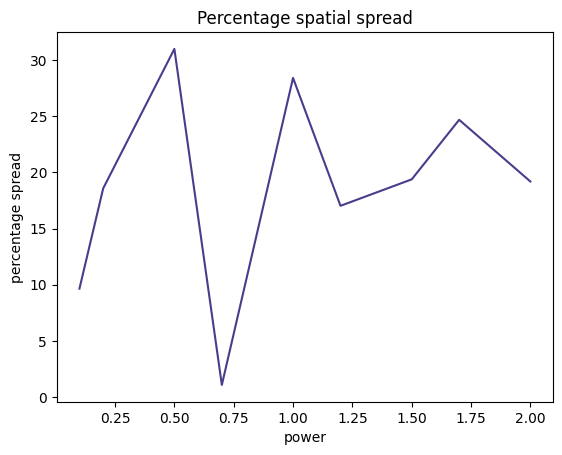

In [56]:
x1=120
x2=280
y1=120
y2=280
spreadByPower=[]
for count,power in enumerate(np.unique(dataOp.laserPowers)):
    trials = np.squeeze(np.argwhere(dataOp.laserPowers==power))
    time = [np.linspace(i+0.07, i+0.1, 100) for i in dataOp.laserOn[trials]]
    activity = dataOp.tToWFManual(time)
    activity = np.mean(activity, axis=0)

    dwf = [np.diff(i, prepend=i[0]) for i in activity]
    dwf = np.array(dwf)

    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1)
    videoROI = videoAvg[x1:x2, y1:y2] # ROI vid with average activity

    videoROI = videoROI.flatten()
    activities = [x for x in videoROI if x <= -75]
    
    spreadByPower.append(len(activities)/((x2-x1)*(y2-y1)))
powers = np.unique(dataOp.laserPowers)
plt.plot(powers,spreadByPower,color='darkslateblue')
# plt.fill_between(spreadByPower[0], \
#                  np.mean(spreadByPower, axis=0)-scipy.stats.sem(spreadByPower,axis=0),\
#                  np.mean(spreadByPower,axis=0)+scipy.stats.sem(spreadByPower,axis=0), color='lavender')
plt.xlabel("power")
plt.ylabel("percentage spread")
plt.title(f'Percentage spatial spread')

##### panels

NameError: name 'spatialResX' is not defined

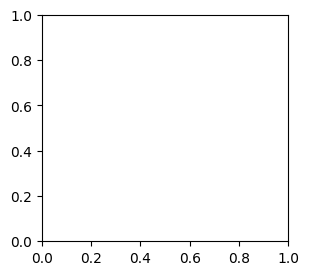

In [53]:
f = plt.figure(figsize=(7,10))
gs=mpl.gridspec.GridSpec(3,2)

ax = plt.subplot(gs[0])
spatialResX(ax)

ax = plt.subplot(gs[1])
xQuant(ax)

ax = plt.subplot(gs[2])
spatialResY(ax)

ax = plt.subplot(gs[3])
yQuant(ax)

x1=120
x2=280
y1=120
y2=280
ax = plt.subplot(gs[4])
squareRes(ax,x1,x2,y1,y2)

ax = plt.subplot(gs[5])
squareQuant(ax,x1,x2,y1,y2)

f.tight_layout()

### figure 4

- activity in the left doesnt predict the right and vice versa

In [326]:
def stimLeft(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000

    pixel_Right=np.ravel_multi_index((200,410),(dataOp.py, dataOp.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp.py,dataOp.px))
    theseTrs = np.argwhere(dataOp.laserPowers==power).ravel()
    onTimes=dataOp.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Upper Left Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [327]:
def stimRight(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp2.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp2.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp2.galvoY==0).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((200,410),(dataOp2.py, dataOp2.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp2.py,dataOp2.px))
    onTimes=dataOp2.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Upper Right 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [328]:
def stimLowerLeft(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp2.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp2.galvoX==0).ravel()
    galvoY=np.argwhere(dataOp2.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,410),(dataOp2.py, dataOp2.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp2.py,dataOp2.px))
    onTimes=dataOp2.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Lower Left Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

In [329]:
def stimLowerRight(ax):
    power = 2
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp2.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp2.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp2.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,410),(dataOp2.py, dataOp2.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp2.py,dataOp2.px))
    onTimes=dataOp2.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Lower Right Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

#### panels

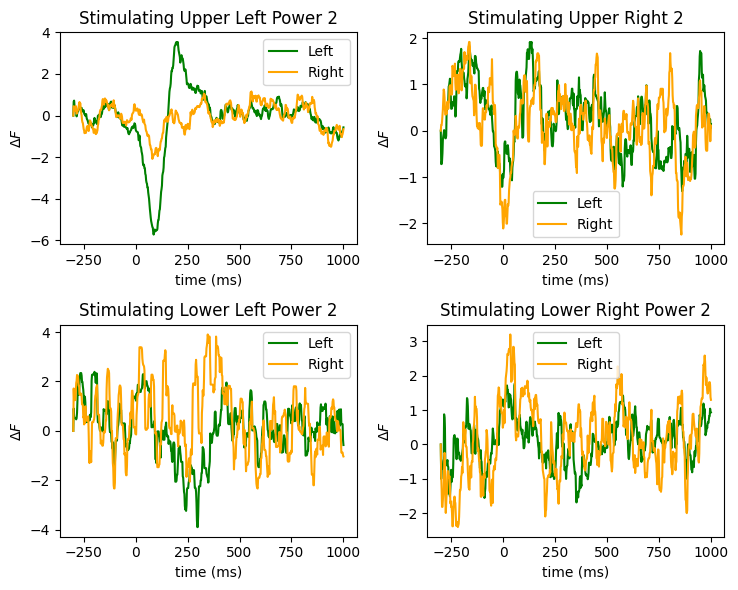

In [330]:
f = plt.figure(figsize=(7.5,6))
gs=mpl.gridspec.GridSpec(2,2)

ax = plt.subplot(gs[0])
stimLeft(ax)

ax = plt.subplot(gs[1])
stimRight(ax)

ax = plt.subplot(gs[2])
stimLowerLeft(ax)

ax = plt.subplot(gs[3])
stimLowerRight(ax)

f.tight_layout()